<h1 style="text-align: center"> Data Preprocessing: Mapping Scraped Restaurants with the Ingredients used and Categorizing Products from the Catalogue

 </h1>

# 1. Importing the libraries

In [129]:
import pickle
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rapidfuzz import fuzz
import ssl
import certifi
import nltk
from collections import Counter
# Use certifi's certificates to resolve the SSL issue
ssl._create_default_https_context = ssl._create_unverified_context

In [24]:
# Download the stopwords and tokenizer (run this once)
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/savinaysingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/savinaysingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 2. Importing the Datasets

In [2]:
# The dataset contains raw HTML tags scraped from Google, which require parsing and cleaning
# to extract meaningful information such as restaurant names, dish details, and prices.
menu_data_tags=pickle.load(open('/Users/savinaysingh/Documents/Interview Preparation/FOBOHChallenge/ans.pkl','rb'))

In [3]:
# List of restaurants
restaurants = [
    "Elements Bar and Grill Walsh Bay",
    "Clam Bar",
    "MuMu",
    "Palazzo Salato",
    "Ragazzi",
    "O Bar and Dining",
    "The Charles Brasserie & Bar",
    "Bopp & Tone",
    "BISTECCA",
    "Cafe Sydney",
    "Santa Catarina: Oaxacan Restaurant & Mezcal Bar Sydney",
    "Grana",
    "Esteban",
    "The Gidley",
    "Primi Italian",
    "Mejico Restaurant",
    "6HEAD Sydney",
    "Restaurant Hubert"
]

In [4]:
# Restaurant - html tags mapping
menu_dict_tags=dict(zip(restaurants,menu_data_tags))

In [122]:
# Product Calalogue Dataset
product_category=['Ham',
 'Pork',
 'Beef',
 'Poultry',
 'Sliced & Pulled Meats',
 'Delicatessen Meats',
 'Continental',
 'Cheese',
 'Soured Cream & Yoghurt',
 'Eggs',
 'Spreads & Fats',
 'Pork Pies',
 'Gourmet Pies',
 'Pies, Pasties & Rolls',
 'Quiche',
 'Savouries',
 'Bacon & Gammon',
 'Salads & Dips',
 'Sandwich Fillings - Dairy',
 'Sandwich Fillings - Seafood',
 'Sandwich Fillings - Chicken',
 'Meatballs',
 'Marinated & Pulled Meat',
 'Canned Meat',
 'Canned Fish',
 'Canned Vegetables',
 'Canned & Dried Fruit',
 'Mayonnaise & Salad Cream',
 'Chutneys & Pickles',
 'Consumer Portions',
 'Condiments & Sauces',
 'Cooking Sauces',
 'Soup',
 'Gravy & Bouillon',
 'Herbs, Spices & Seasoning',
 'Dried Pasta & Rice',
 'Oils',
 'Preserves, Fruit Fillings & Toppings',
 'Sugar & Sweetners',
 'Bakery Products & Mixes',
 'Breakfast Cereals',
 'Confectionery',
 'Biscuits',
 'Traybakes',
 'Crisps & Scratchings',
 'Cake',
 'Sausage',
 'Burgers & Sandwich Steaks',
 'Chicken',
 'Seafood',
 'Pies',
 'Pasties & Slices',
 'Savoury Rolls',
 'Savoury Buffet',
 'Asian Savouries',
 'Ingredient Pastry & Yorkshire Puddings',
 'Bread',
 'Potato Products',
 'Meal Solutions',
 'Vegetables & Fruit',
 'Desserts',
 'Individual Cakes & Desserts',
 'Traycakes & Slices',
 'Sweet Pastries']


In [123]:
product_category=[x.lower() for x in product_category]

# 3. Data Preprocessing

## 3.1. Parsing HTML to Create Restaurant-Menu Item Mappings

In [6]:
def extract_menu_items_from_restaurants(menu_dict_tags):
    # Initialize an empty DataFrame to store results
    df = pd.DataFrame()

    # Iterate over each restaurant in the menu_dict_tags
    for restaurant, html_content in menu_dict_tags.items():
        # Parse the HTML content for each restaurant
        soup = BeautifulSoup(str(html_content), 'html.parser')

        # List to store extracted menu items
        menu_items = []

        # Find all menu items
        for item_div in soup.find_all("div", class_="j0bkC"):
            name = item_div.find("div", class_="gq9CCd").text if item_div.find("div", class_="gq9CCd") else "N/A"
            description = item_div.find("span", class_="lum-fi-dl").text if item_div.find("span", class_="lum-fi-dl") else "N/A"
            price = item_div.find("span", class_="fUcQpe").text if item_div.find("span", class_="fUcQpe") else "N/A"

            # Append extracted details to the list
            menu_items.append({
                "Restaurant": restaurant,
                "Dish": name,
                "Key_Ingredients": description,
                "Price": price
            })

        # Append the extracted menu items to the DataFrame
        df = pd.concat([df, pd.DataFrame(menu_items)], ignore_index=True)

    return df

In [8]:
df=extract_menu_items_from_restaurants(menu_dict_tags)

In [10]:
# Menu for the restaurant named 'Esteban' 
df[df['Restaurant']=='Esteban']

,Restaurant,Dish,Key_Ingredients,Price
670,Esteban,Smoked Black Bean Dip,"corn totopos, salsa macha oil, lime (gf)(⊽)",$16.00
671,Esteban,Tasmanian Salmon Ceviche Taco,"each cilantro, chilli, onion, crisp yellow cor...",$11.00
672,Esteban,Beef Tartare Taco,"each egg jam, mountain pepper leaf, papas al h...",$14.00
673,Esteban,Tostada De Berenjena,"each smoked bean purée, avocado, mahon cheese,...",$12.00
674,Esteban,Pink Ling Ceviche,"leche de tigre, karkalla, plantain frito (gf)(df)",$27.00
675,Esteban,Taco Al Pastor,"each adobo marinated pork, tomatillo salsa, ro...",$14.00
676,Esteban,Prawn Taco,"each tomatillo, salsa Mexicana, hand made corn...",$14.00
677,Esteban,Fire Roasted SA Calamari,"mole de mar, bottarga, salsa verde (gf)(df)",$35.00
678,Esteban,Sautéed Vongole,"chorizo and chipotle butter, cactus, chochoyot...",$34.00
679,Esteban,Seared Pork Belly,"pickled watermelon radish, baby onions, salsa ...",$28.00


## 3.2. Handling the missing values 

In [12]:
# Removing the data where dish is empty/null
df=df[df['Dish']!='N/A']

In [13]:
# Handling missing data for Key_Ingredients
df_missing=df[df['Key_Ingredients']=='']

In [15]:
df_missing=df_missing[0:485]

In [191]:
# Load the list of key ingredients from a pickle file
# The 'GenAIOutput.pkl' file contains preprocessed ingredient data generated by a model
ans_list = pickle.load(open('GenAIOutput.pkl', 'rb'))

# Assign the loaded list of key ingredients to the 'Key_Ingredients' column in the df_missing DataFrame
df_missing['Key_Ingredients'] = ans_list

# Create a new DataFrame df_full that contains only the rows from df where 'Key_Ingredients' is not empty
df_full = df[df['Key_Ingredients'] != '']

# Concatenate the df_full DataFrame with df_missing to create a comprehensive DataFrame
# This includes both full records and records with missing key ingredient data
df = pd.concat([df_full, df_missing])

# Save the final concatenated DataFrame to a CSV file named 'preprocessed_v1.csv'
# This CSV file will contain the cleaned and processed data ready for further analysis
df.to_csv('preprocessed_v1.csv', index=False)  # Ensure to include index=False to avoid writing row indices


In [78]:
df=pd.read_csv('preprocessed_v1.csv')
df=df[~df.Key_Ingredients.isna()]

## 3.3. Handling weight units, punctuation, numerics and other noise

In [79]:
def remove_weight_units(text):
    # Define the regex pattern to match weight units, including those in parentheses
    pattern = r'\b\d*\s*(g|kg|ml|l|oz|lbs|gf|df)\b|\(\s*(g|kg|ml|l|oz|lbs|gf|df)\s*\)'

    # Substitute matched patterns with an empty string
    cleaned_text = re.sub(pattern, '', text.lower())
    
    # Remove any extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

In [80]:
remove_weight_units('smoked kipflers, roasted jalapeño crema  (g) (gf)(df)')

'smoked kipflers, roasted jalapeño crema'

In [81]:
df.Key_Ingredients=[remove_weight_units(x) for x in df.Key_Ingredients]

In [82]:
# 85 - 101 useless data
df[85:102]

,Unnamed: 0,Restaurant,Dish,Key_Ingredients,Price
85,593,Grana,"Freshly shucked oysters, blood orange and pros...","ea sydney rock oysters, nsw",$6.50
86,594,Grana,"Kingfish crudo, spring onion verde, mandarin, ...","spencer gulf, sa",$30.00
87,595,Grana,"Yellowfin tuna tartare, avocado, agrodolce dre...","bermagui, nsw",$32.00
88,596,Grana,"Citrus glazed king prawns, black pepper aioli,...","skull island, nt",$42.00
89,597,Grana,"Humpty doo barramundi, spring green peas charr...","middle point, nt",$45.00
90,598,Grana,"Market Fish, cime di rapa, lemon and caperberr...",locally sourced,NaN
91,604,Grana,Take our bread home,house baked daily,$12.00
92,605,Grana,"Smoked raw beef, black garlic, guindillas, pec...","glen innes, nsw",$29.00
93,606,Grana,"Grilled free-range chicken, saffron risoni, re...","byron bay hinterland, nsw",$42.00
94,607,Grana,"Pork cotoletta, fennel, pickled apple, tarrago...","ebenezer, nsw",$43.00


In [83]:
df = df.drop(index=range(85, 102)).reset_index(drop=True)
df=df.reset_index(drop=True)

In [84]:
# Replacing &s with a comma
df.Key_Ingredients=df.Key_Ingredients.str.replace("&", ",", regex=False)

In [86]:
def clean_ingredients(ingredients_list):
    cleaned_ingredients = []
    
    for item in ingredients_list:
        # Remove unwanted punctuation (keeping only commas and spaces)
        item = re.sub(r"[^\w\s,]", "", item)
        
        # Normalize whitespace
        item = re.sub(r'\s+', ' ', item).strip()
        
        # Convert to lowercase
        item = item.lower()
        
        # Remove any numeric values, if needed (you can keep them by commenting the next line)
        item = re.sub(r'\d+', '', item)
        
        # Append the cleaned item to the list
        cleaned_ingredients.append(item)
    
    return cleaned_ingredients

In [87]:
df.Key_Ingredients=clean_ingredients(df.Key_Ingredients)

## 3.4. Removal of stop words

In [101]:
stop_words = set(stopwords.words('english'))


In [102]:
df.Key_Ingredients=[' '.join([word for word in x.split() if word not in stop_words]) for x in df.Key_Ingredients]

## 3.5. Handling the outliers

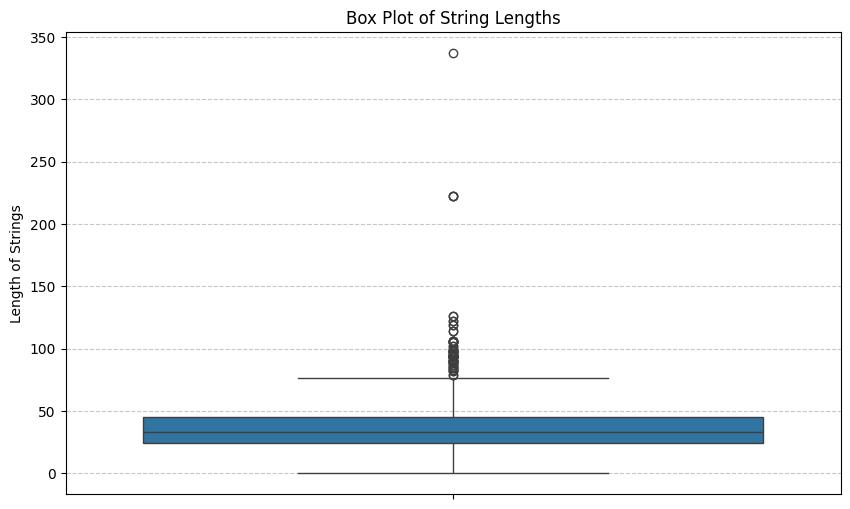

In [103]:
def plot_string_length_outliers(string_list):
    # Calculate lengths of strings
    lengths = [len(s) for s in string_list]

    # Create a box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=lengths)

    # Customizing the plot
    plt.title('Box Plot of String Lengths')
    plt.ylabel('Length of Strings')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.show()

# Call the function
plot_string_length_outliers(df.Key_Ingredients)

In [104]:
[x for x in df.Key_Ingredients if len(x)>150]

['cheeses served quince paste, seasonal chutney, grape, fruit loaf wafer, lavoshartisan extravagant, cow milk timboon, victoria bay fires cheddar, cow milk st helens, tasmania kris lloyd rusty cheese, cow milk adelaide hills, sa holy goat la luna, goat milk goldfields, victoria berrys creek riverine blue, buffalo milk gippsland, victoria',
 'single roasted blended botany, sydney using highest quality beans world collider, blend brazilian, ethiopian , papua new guinean beans, always savoured ripe berry characteristics, hints spice , bittersweet chocolate finish',
 'mbs family farm tablelands nsw perrys long history raising australias top wagyu served black garlic , chipotle butter requires minimum cooking time hours please note thursday saturday reservations item requires preorder pm',
 'mbs family farm tablelands nsw perrys long history raising australias top wagyu served black garlic , chipotle butter requires minimum cooking time hours please note thursday saturday reservations item 

In [111]:
# Outliers
[s for s in df.Key_Ingredients if len(s) <= 3]

['', '', '', '', 'pp']

In [115]:
# Outliers
[s for s in df.Key_Ingredients if len(s) >= 150]

['cheeses served quince paste, seasonal chutney, grape, fruit loaf wafer, lavoshartisan extravagant, cow milk timboon, victoria bay fires cheddar, cow milk st helens, tasmania kris lloyd rusty cheese, cow milk adelaide hills, sa holy goat la luna, goat milk goldfields, victoria berrys creek riverine blue, buffalo milk gippsland, victoria',
 'single roasted blended botany, sydney using highest quality beans world collider, blend brazilian, ethiopian , papua new guinean beans, always savoured ripe berry characteristics, hints spice , bittersweet chocolate finish',
 'mbs family farm tablelands nsw perrys long history raising australias top wagyu served black garlic , chipotle butter requires minimum cooking time hours please note thursday saturday reservations item requires preorder pm',
 'mbs family farm tablelands nsw perrys long history raising australias top wagyu served black garlic , chipotle butter requires minimum cooking time hours please note thursday saturday reservations item 

In [116]:
df=df[(df['Key_Ingredients'].str.len() < 150) & (df['Key_Ingredients'].str.len() > 3)]


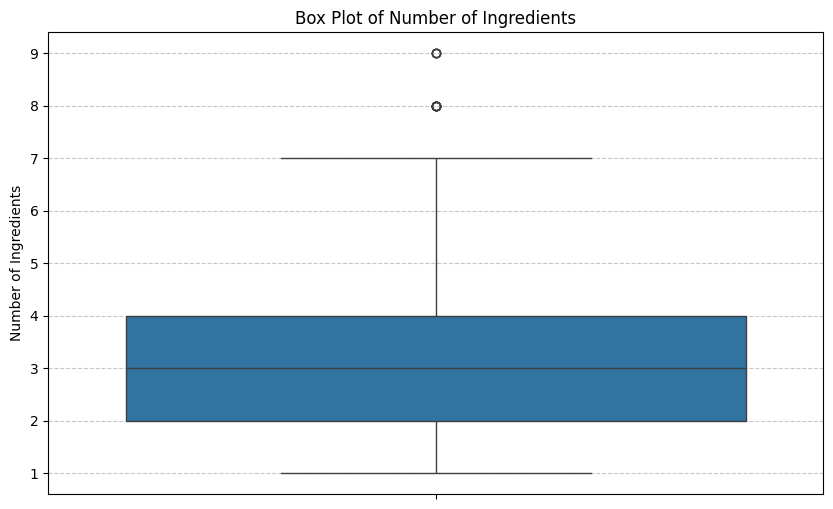

In [117]:
def plot_number_of_ingredients_outliers(ingredient_list):
    # Calculate the number of ingredients by splitting the strings by commas
    num_ingredients = [len(ingredients.split(',')) for ingredients in ingredient_list]

    # Create a box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=num_ingredients)

    # Customizing the plot
    plt.title('Box Plot of Number of Ingredients')
    plt.ylabel('Number of Ingredients')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.show()

# Call the function with the ingredient list
plot_number_of_ingredients_outliers(df.Key_Ingredients)

In [118]:
[x.split(',') for x in df.Key_Ingredients if len(x.split(','))>7]

[['month aged prosciutto',
  ' salami',
  ' double smoked ham',
  ' mortadalla',
  ' olives',
  ' cheeses',
  ' bread',
  ' roasted vegetables ',
  ' stuffed baby pepper'],
 ['san marzano tomato sauce',
  ' fior di latte',
  ' mushroom',
  ' zucchini',
  ' eggplant',
  ' red pepper',
  ' cherry tomato ',
  ' oregano'],
 ['san marzano tomato sauce',
  ' vegan cheese',
  ' mushroom',
  ' zucchini',
  ' eggplant',
  ' red pepper',
  ' cherry tomato ',
  ' oregano'],
 ['san marzano tomato sauce',
  ' mild salami',
  ' italian sausage',
  ' bacon',
  ' wood fired pepper',
  ' olives',
  ' mushrooms ',
  ' fior di latte cheese'],
 ['tomato base',
  ' chicken',
  ' mushrooms',
  ' olives',
  ' onion',
  ' wood fired pepper',
  ' oregano ',
  ' mozzarella'],
 ['tomato base',
  ' mild salami',
  ' bacon',
  ' italian sausage',
  ' wood fired pepper',
  ' onion',
  ' olives',
  ' mushrooms ',
  ' mozzarella'],
 ['month aged prosciutto',
  ' salami',
  ' double smoked ham',
  ' mortadalla',
  ' o

In [119]:
[x.split(',') for x in df.Key_Ingredients if len(x.split(','))<2]

[['tower'],
 ['serving ice cold delicacies'],
 ['assortment grilled lamb cuts'],
 ['grass fed house patty'],
 ['zucchini flower gooseberry hot sauce'],
 ['house mignonette'],
 ['selection fresh market seafood'],
 ['sauce américaine'],
 ['mbs sauce bordelaise'],
 ['per grams'],
 ['per piece'],
 ['la diabla sauce'],
 ['pp milled onsite heritage grains gunnedah'],
 ['stracchino cheese thin layers olive oil bread'],
 ['mozzarella pocket filled cows milk cream'],
 ['thin strands hand pulled mozzarella'],
 ['ea whipped ricotta charred bread'],
 ['thin strands angel hair egg dough'],
 ['hand pressed seashell shaped pasta'],
 ['café de olla pot coffee ice cream'],
 ['café de olla pot coffee ice cream'],
 ['loligo baby calamari served homemade lemon aioli'],
 ['mix berries coulis'],
 ['grated dark chocolate'],
 ['seasonal roasted vegetables served lemon butter sauce'],
 ['spaghetti slow cooked beef mince san marzano napolitana sugo basil'],
 ['rich red cabernet napolitano garlic sauce'],
 ['chi

# 4. Restaurant - Ingredients Mapping

In [130]:
# Dictionary to store ingredient frequencies for each restaurant
restaurant_ingredients = {}

# Loop through each restaurant and its corresponding key ingredients
for restaurant, ingredients in df.groupby('Restaurant')['Key_Ingredients']:
    # Combine all key ingredients for a restaurant into one list, split by commas, and strip whitespace
    all_ingredients = ', '.join(ingredients).split(', ')
    
    # Count the frequency of each ingredient using Counter
    ingredient_counter = Counter(all_ingredients)
    
    # Store the ingredient frequencies in the dictionary
    restaurant_ingredients[restaurant] = ingredient_counter

# Display the result
for rest, ing_counter in restaurant_ingredients.items():
    print(f"{rest}: {dict(ing_counter)}")

6HEAD Sydney: {'vg fresh cherry tomatoes': 1, 'basil onion served woodfired vienna bread': 1, 'v crispy': 1, 'fried sicilian balls rice made vegetables': 1, 'provolone ': 1, 'buffalo mozzarella cheese served arrabbiata sauce': 1, 'v fresh ricotta cheese': 1, 'sundried tomato ': 1, 'homemade lemon aioli': 1, 'loligo baby calamari served homemade lemon aioli': 1, 'san marzano napolitana ': 1, 'garlic sauce': 1, 'beetroot infused salmon carpaccio served rocket ': 1, 'capers salad evoo green lemon vinaigrette': 1, 'three cheese': 1, 'roasted capsicum ': 1, 'chilli dip': 1, 'month aged prosciutto': 1, 'salami': 1, 'double smoked ham': 2, 'mortadalla': 1, 'olives': 7, 'cheeses': 1, 'bread': 1, 'roasted vegetables ': 1, 'stuffed baby pepper': 1, 'v': 2, 'fresh mixed lettuce': 2, 'cucumber': 2, 'cherry tomatoes': 3, 'red onion': 2, 'mixed olives red wine vinegar ': 1, 'evoo': 2, 'local giant king prawns bed mixed leaf salad avocado': 1, 'cucumber ': 1, 'orange vinaigrette': 1, 'vine ripened to

In [131]:
# pickle.dump(restaurant_ingredients,open('restaurant_ingredients.pkl','wb'))

In [126]:
# pickle.dump(product_category,open('product_catalogue.pkl','wb'))

In [133]:
# df.to_csv('preprocessed_restaurant.csv')